In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.up_conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.up_conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.up_conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.up_conv4(x)
        
        return torch.sigmoid(self.outc(x))

class RetinalSegmentation:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = UNet().to(self.device)
        
    def train(self, train_loader, num_epochs=10):
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.model.parameters())
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            
            for images, masks in train_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
    
    def predict(self, image):
        self.model.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(self.device)
            mask = self.model(image)
            return mask.squeeze().cpu().numpy()

Epoch 1, Loss: 0.0418017288067096
Epoch 2, Loss: 0.001609693917772381
Epoch 3, Loss: 0.000548272874702398
Epoch 4, Loss: 0.00026700090979471324
Epoch 5, Loss: 0.00015235599610424134
Epoch 6, Loss: 9.516778405834496e-05
Epoch 7, Loss: 6.289033483266077e-05
Epoch 8, Loss: 4.31196381987886e-05
Epoch 9, Loss: 3.0365400720505804e-05
Epoch 10, Loss: 2.1810115581181256e-05
Predicted mask shape: (256, 256)


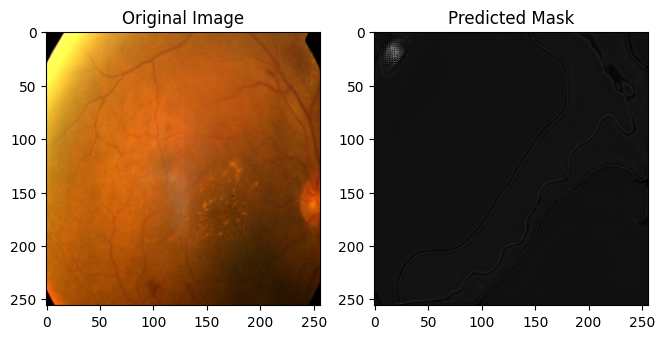

In [2]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


class RetinalDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir) if mask_dir else None
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = str(self.image_dir / self.images[idx])
        image = Image.open(img_path).convert('RGB')
        
        # Load mask if mask_dir is provided
        if self.mask_dir:
            mask_path = str(self.mask_dir / self.images[idx])  # Assuming mask has same name as image
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        else:
            mask = Image.new('L', image.size, 0)  # Create dummy mask if not provided
        
        # Apply transforms
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        
        image = transform(image)
        mask = transform(mask)
        
        return image, mask

dataset = RetinalDataset(
    image_dir='test_images'  # Optional: remove if you don't have masks
)

train_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True
)

# Initialize and train the model
segmentation = RetinalSegmentation()
segmentation.train(train_loader, num_epochs=10)


sample_image, _ = dataset[0]  # Get first image from dataset
predicted_mask = segmentation.predict(sample_image)
print("Predicted mask shape:", predicted_mask.shape)

# Optional: Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(sample_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title('Original Image')

plt.subplot(132)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

if dataset.mask_dir: 
    plt.subplot(133)
    plt.imshow(dataset[0][1].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')

plt.show()